# Comparing different calibrations

To test the compensation for vignetting and colour crosstalk, we've set the camera up with a 50mm focal length doublet lens.  This has pretty constant Chief Ray Angle across the sensor (not perfect, but much more constant than the stock lens).  It can also image things, so we can display a test pattern and see how it's imaged by the camera.

In [23]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from picam_raw_analysis.extract_raw_image import load_raw_image
import sys
import os
import numbers
import scipy.ndimage as ndimage

%matplotlib inline
matplotlib.rc('text', usetex=False)
matplotlib.rc('font',family='serif', serif=['tex gyre termes', 'DejaVu Serif'], size=8)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('savefig', pad_inches=0)
manuscript_linewidth=4.774 # this saves re-scaling things afterwards

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load images and plot raw data
There are four images in ``data_folder``, corresponding to red, green, blue, and white illumination.  There is also a test image of the colour chart.  These are loaded in using the same code as for the other analysis notebooks.

The images plotted by this cell are what is obtained from the sensor, under red, gree, and blue illumination, after binning and adjusting the black level to zero.  Each column represents an illumination colour (white, red, green, then blue) and each row represents a colour channel in the image.  The final row is the RGB image, extracted from the raw data with minimal additional processing.

In [24]:
from matplotlib.colors import LinearSegmentedColormap

def bin(image, b=2):
    """Bin bxb squares of an image together"""
    w,h = image.shape[:2]
    new_shape = (w//b, b, h//b, b)
    if len(image.shape) > 2:
        new_shape += image.shape[2:]
    if w % b != 0 or h % b != 0:
        print("Warning: pixels are being dropped from the binned image!")
        image = image[:w - (w%b), :h - (h%b), ...]
    return image.reshape(new_shape).mean(axis=1).mean(axis=2)

def load_raw_image_and_bin(filename):
    """Load an image from the raw data in a jpeg file, and return a binned version."""
    pi_bayer_array = load_raw_image(filename)
    image = pi_bayer_array.array - np.array([16,32,16])[np.newaxis,np.newaxis,:] # correct for the zero offset in the raw data
    return bin(image, 16)
def load_run(folder, illuminations):
    """Load the R,G,B,W calibration images and any additional images."""
    output = {}
    for k, rgb in illuminations.items():
        output[k] = load_raw_image_and_bin(os.path.join(folder, "capture_r{}_g{}_b{}.jpg".format(*rgb)))
    for f in os.listdir(folder):
        if f.startswith("additional_image_"):
            output[f[17:-4]] = load_raw_image_and_bin(os.path.join(folder, f))
    return output
    
# These are some utility functions that label the plots nicely
def col_titles(axes, titles):
    for topax, title in zip(axes, titles):
        topax.set_title(title)
def wrgb_col_titles(axes):
    col_titles(axes, ["white", "red", "green", "blue", "black"][:len(axes)])
def row_titles(axes, titles, offset=(0,0)):
    for ax, title in zip(axes, titles):
        ax.annotate(title, xy=(0, 0.5), xytext=offset,
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='left', va='center', rotation="vertical")
        
def imshow_with_section(ax, image, clip=True, whitepoint=255., section=True):
    """Convert an image to 8 bit and display it in the axes.
    
    if clip==True (default) pixels are constrained to 0-255, to avoid overflow.
    if section==True (default) line graphs are overlaid for R,G,B sections through the image.
    ax should be a matplotlib Axes instance into which we plot, and image is the NxMx3 
    array that we are displaying.
    """
    if isinstance(whitepoint, numbers.Number):
        normalised_image = image/whitepoint*255.
    elif whitepoint == "max" or whitepoint is np.max:
        normalised_image = image / np.max(image) * 255.
    elif whitepoint == "channel_max":
        normalised_image = image / np.max(image, axis=(0,1)) * 255.
        
    if clip:
        clipped_image = image.copy()
        clipped_image[clipped_image<0] = 0
        clipped_image[clipped_image>255] = 255
    else:
        clipped_image = image
    ax.imshow(clipped_image.astype(np.uint8), origin="bottom")
    x = np.arange(image.shape[1])
    h = image.shape[0]
    if section:
        for i, col in enumerate(["red","green","blue"]):
            ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color=col)
            ax.plot(x, image[h//2, :, i]/255.0*h/2.0, color="dark"+col, dashes=(2,4))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
        
# Load the data:
illuminations = {"W":(255,255,255), "R":(255,0,0), "G":(0,255,0), "B":(0,0,255), "K":(0,0,0)}
# Load the images where a solid colour was displayed across the whole screen
data_folder = "../data/monitor_and_50mm_lens/"
keys = [f for f in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder,f))]
runs = {k: load_run(os.path.join(data_folder, k), illuminations) for k in keys}
runs_backup = {run_name: {im_name: image.copy() for im_name, image in run.items()}
               for run_name, run in runs.items()} # in case we overwrite by accident!



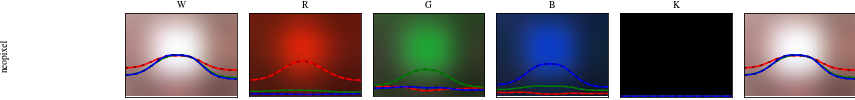

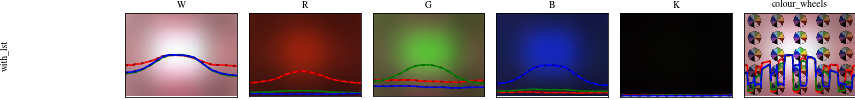

In [25]:
def plot_run(run, norm=None):
    if norm is None:
        norm = 1
    elif norm == "centre":
        norm = 255./np.max(run['W'], axis=(0,1))
    elif norm == "white":
        norm = 255./run['W']
    
    f, ax = plt.subplots(1, 6, tight_layout=True, figsize=(12,3))
    norm_centre = 255. / np.max(run['W'], axis=(0,1))
    for i,k in enumerate(["W","R","G","B","K","colour_wheels"]):
        try:
            imshow_with_section(ax[i], run[k]*norm)
            ax[i].set_title(k)
        except KeyError:
            imshow_with_section(ax[i], run['W']*norm)
    return f, ax

for n, run in runs.items():
    f, ax = plot_run(run, norm="centre")
    row_titles([ax[0]], [n])

'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


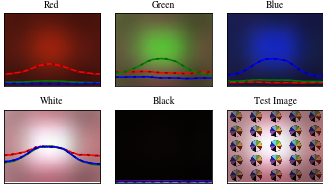

In [26]:
run = runs['flat_lst']
norm = 255./np.max(run['W'], axis=(0,1))
f, ax = plt.subplots(2, 3, tight_layout=True, figsize=(manuscript_linewidth,2.8))
titles = {"R":"Red","G":"Green","B":"Blue","W":"White","K":"Black","colour_wheels":"Test Image"}
for i,k in enumerate(["R","G","B","W","K","colour_wheels"]):
    imshow_with_section(ax.flatten()[i], run[k]*norm, section=k!="colour_wheels")
    ax.flatten()[i].set_title(titles[k])
f.savefig("../manuscript/artwork/example_run.pdf")

**Figure:** An example set of calibration and test images, normalised only for overall brightness.

Just to convince you that this really is an angle-of-incidence effect, here are two images, where the sensor is tilted between the two:

'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


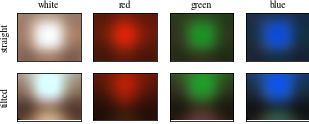

In [27]:
rgbw_illuminations = {k: v for k, v in illuminations.items() if k != "K"}
straight = load_run("../data/calibration_jig_r3/straight", rgbw_illuminations)
tilted = load_run("../data/calibration_jig_r3/cw", rgbw_illuminations)

norm = 255./np.max(straight['W'], axis=(0,1))

f, ax = plt.subplots(2, 4, figsize=(manuscript_linewidth,2.0))
for i, run in enumerate([straight, tilted]):
    for j, illum in enumerate(['W','R','G','B']):
        imshow_with_section(ax[i,j], run[illum]*norm, section=False)
        
wrgb_col_titles(ax[0,:])
row_titles(ax[:,0],["straight", "tilted"])
f.subplots_adjust(left=0.05)

f.savefig("../manuscript/artwork/straight_vs_tilted.pdf")

## Next, normalise
The built-in compensation normalises so that a white image comes out white - i.e. it divides through by a reference image.  Taking and dividing through by the white image from each calibration gives the following:

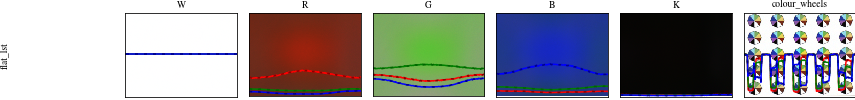

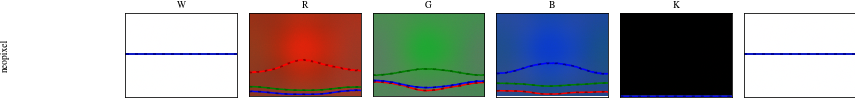

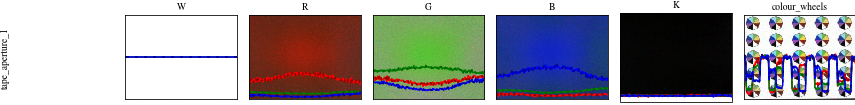

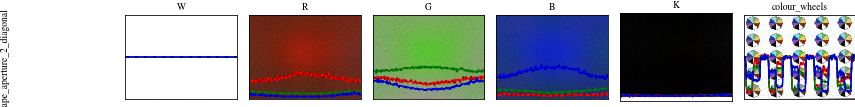

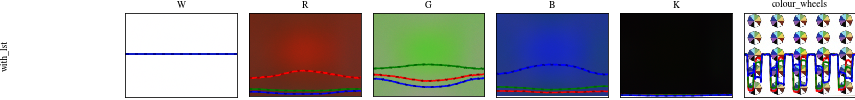

In [28]:
for n, run in runs.items():
    f, ax = plot_run(run, norm="white")
    row_titles([ax[0]], [n])

'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


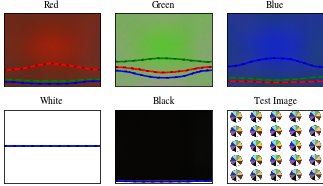

In [29]:
# Plot just the first one, in a nicer format
run = runs['flat_lst']
norm = 255./run['W']
f, ax = plt.subplots(2, 3, tight_layout=True, figsize=(manuscript_linewidth, 2.8))
titles = {"R":"Red","G":"Green","B":"Blue","W":"White","K":"Black","colour_wheels":"Test Image"}
for i,k in enumerate(["R","G","B","W","K","colour_wheels"]):
    imshow_with_section(ax.flatten()[i], run[k]*norm, section=k!="colour_wheels")
    ax.flatten()[i].set_title(titles[k])
f.savefig("../manuscript/artwork/example_run_normalised.pdf")

**Figure:** An example set of images, divided through by the white image (i.e. with lens shading correction applied).

The lens shading correction (dividing by a reference white image) has made the background uniform - but this isn't always possible.  An interesting question is how well the calibration transfers.  To start with, let's compare cross-sections of the white images for each calibration run.

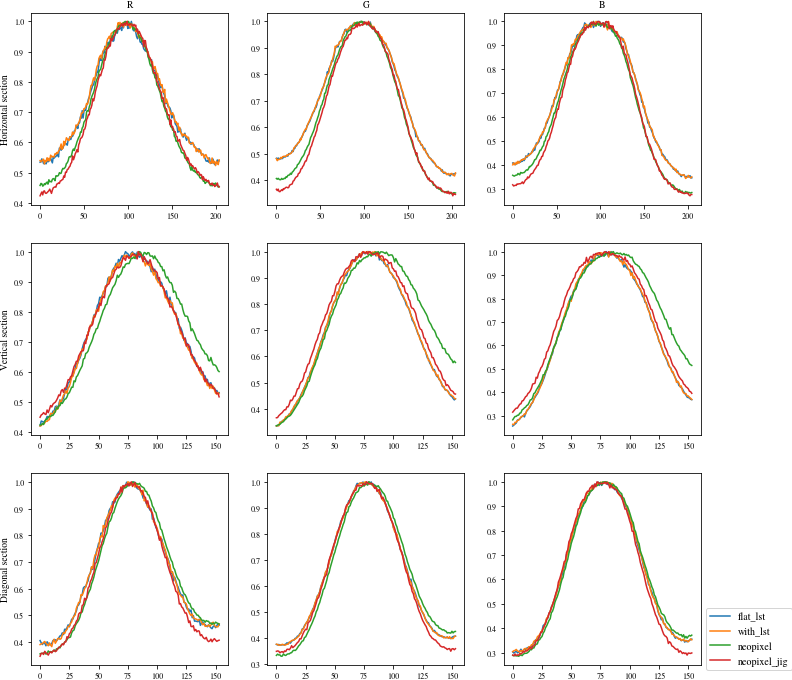

In [30]:
def section0(arr):
    return arr[arr.shape[0]//2,...]
def section1(arr):
    return arr[:,arr.shape[1]//2,...]
def sectiond(arr):
    return np.diagonal(arr, axis1=0, axis2=1, offset=(arr.shape[1]-arr.shape[0])//2).T
section_functions = [section0, section1, sectiond]

f, ax = plt.subplots(3,3,figsize=(12,12))
#for run_name in runs.keys():
for run_name in ["flat_lst", "with_lst", "neopixel", "neopixel_jig"]:
    run = runs[run_name]
    white = run['W']
    for i, k in enumerate(['R','G','B']):
        channel = run[k][:,:,i]
        for j, section in enumerate(section_functions):
            s = section(channel)
            ax[j,i].plot(s[:]/np.max(s[:]), label=run_name)
ax[2,2].legend(loc='lower left', bbox_to_anchor=(1.0, -0.05), ncol=1)
row_titles(ax[0:3, 0], ["Horizontal section","Vertical section", "Diagonal section"],offset=(-10,0))
col_titles(ax[0,:], ["R","G","B"])

It's interesting to note that:
* The different calibrations all look broadly similar
* The correction required for the two setups with the largest aperture (approximately f/6) is less extreme (perhaps due to it being "fuzzed out" by the wider range of angles?)
* The performance is broadly similar in all cases

We can split the correction into a few different steps, each represented by a different matrix.  This is helpful because it means we don't have to acquire enough information for the entire correction each time we recalibrate.  The three bits I'm considering are:
* Lens shading table/white image normalisation $\mathit{LST}_{ij}$.  This has $w\times h\times 3$ degrees of freedom, i.e. it's an image.  In this analysis, this is performed first, i.e. before correcting for colour crosstalk.  Note that the Raspberry Pi's pipeline is usually set up with each channel normalised to have unity gain for the brightest pixel, so that the lens shading table does not affect colour balance.  Simply dividing through by a white image applies both the lens shading table and the colour balance.
* Colour balance matrix: $\mathit{Cb}_{pq}$this is a diagonal $3\times 3$ matrix, responsible for equalising the gains of the different components of the image.  This has three degrees of freedom, though normally the gain for the green channel is fixed at unity (in order to avoid changing the overall brightness too much) and thus there are only two meaningful degrees of freedom.
* Colour response matrix: $\mathit{Cx}_{pq}$this is $3\times 3$ i.e. it's a matrix that maps colour to colour, and is not spatially varying.  It should depend on the overlap of the spectra of the three illumination colours used and the camera's colour filters.  This matrix may also apply colour balance, so if $\mathit{Cb}_{pq}$ is to be meaningful, we must define this matrix to be unitary, i.e. it should not change the overall balance of the colours.
* Spatially varying colour-unmixing matrix $\mathit{U}_{ijpq}$: this describes leakage of one channel to another.  Depending on how this is calculated, it may include both $\mathit{Cb}_{pq}$ and $\mathit{Cx}_{pq}$, but it is possible to split these out.  We define $\mathit{U}_{ijpq}$ such that it does not affect the colour balance or colour crosstalk at the brightest point of the image (generally the centre).

The normalisation we've done to images above, dividing through by a white image, combines $\mathit{LST}$ and $\mathit{Cb}$, i.e. if we have a white image $W_{ijp}$ (where the white level is 255),
$$ \mathit{Cb}_{pp}\mathit{LST}_{ijp} = {255 \over W_{ijp}} $$

If we start with an unnormalised image $\mathrm{Image}_{ijp}$, we can colour-correct and unmix by doing:
$$\mathit{Pure}_{ijp} = \sum_{qr}\mathit{U}_{ijpq}\mathit{Cx}_{qr}\mathit{Cb}_{rr}\mathit{LST}_{ijr}\mathrm{Image}_{ijr}$$

This will unmix the colours such that the images taken under red, green, and blue illumination become pure red, green, or blue.  However, if we just want to normalise colour response across the sensor (which has lower noise and more normal-looking colours) we simply remove $\mathit{Cx}$:
$$\mathit{Unmixed}_{ijp} = \sum_{q}\mathit{U}_{ijpq}\mathit{Cb}_{qq}\mathit{LST}_{ijq}\mathrm{Image}_{ijq}$$


## Calculating colour crosstalk
We can construct a matrix that tells us about colour crosstalk using images taken of uniform red, green, and blue illuminations.  We stack normalised images along the final dimension, i.e. we normalise each of the 3 coloured images by dividing through by a white reference image, then combine them.  The indices in this matrix are:
1. y coordinate
2. x coordinate
3. sensor (recorded) colour channel
4. illumination (true) colour channel
That means that $\mathit{Crosstalk}_{ijpq}$ is equal to $\mathit{Cb}_{pp}\mathit{LST}_{ijp}\mathit{Colour}_{ijp}$ where $\mathit{Colour}$ is a red, green, or blue image for $q=0, 1, 2$ respectively.

What we want to do now is invert each matrix (a $3\times3$ image per pixel) to create a transformation that will recover the colours, assuming crosstalk is linear.  Inverting the sub-matrices defined by the last 2 indices will give $\mathit{U}_{ijpq}\mathit{Cx}_{qr}$ i.e. it completely unmixes the recorded colours to give pure (oversaturated) colours.

It's possible to get back the same colour response as the centre of the image, if we normalise to the central region.  This involves calculating $\mathit{Cx}_{qr}$ based on the mean value of the central few pixels, and doing a matrix multiplication such that we transform from pure colours back to regular colours.  This happens in ``colour_unmixing_matrices`` if the argument ``colour_target="centre"``.

In [31]:
def crosstalk_matrices(run):
    """Construct a 4d array of colour crosstalk information.
    
    This function returns a 3x3 matrix at each pixel of the calibration images.
    Inverting this matrix """
    return np.stack([run[k] for k in ['R', 'G', 'B']], axis=3)/run['W'][:,:,:,np.newaxis]

def central_colour(image):
    # Find the colour of the central portion of an image
    w,h = image.shape[:2]
    return np.mean(np.mean(image[w*4//9:w//2+w*5//9, h*4//9:h*5//9, ...], axis=0), axis=0)

def colour_unmixing_matrices(cal, colour_target="rgb", smoothing=None):
    """Return a matrix that turns the camera's recorded colour back into "perfect" colour
    
    cal should be a calibration run (dictionary) with, as a minimum, W, R, G, and B images.
    
    calibration: a dictionary with (at least) R, G, B, and W images
    colour_target: "rgb" (default) or "centre".  "rgb" will unmix to fully saturated colours,
        while "centre" will unmix so the edges of the image match the centre of the image.
    smoothing: None (default) for no smoothing, or a number (in pixels) to apply a Gaussian
        blur to the compensation matrices.
        
    returns:
    an NxMx3x3 unmixing matrix
    """
    crosstalk = crosstalk_matrices(cal)
    compensation_matrices = np.empty_like(crosstalk)
    # Doing this with a massive for loop is inefficient, but easy to read!
    for i in range(crosstalk.shape[0]):
        for j in range(crosstalk.shape[1]):
            compensation_matrices[i,j,:,:] = np.linalg.inv(crosstalk[i,j,:,:])
    if colour_target == "centre" or colour_target == "center":
        central_response = np.array([central_colour(cal[k]/cal['W']) for k in ['R', 'G', 'B']])
        print("Adding up the R/G/B images, we get:", np.sum(central_response, axis=0))
        compensation_matrices = np.sum(compensation_matrices[:,:,:,np.newaxis,:]
                              *central_response[np.newaxis,np.newaxis,:,:,np.newaxis], 
                              axis=-3)
    if smoothing is not None:
        compensation_matrices = ndimage.gaussian_filter(compensation_matrices, (smoothing,smoothing,0,0), order=0)
    return compensation_matrices

def normalised_colour_wheels(run):
    return run['colour_wheels']/run['W']*255.

def colour_unmix_image(image, calibration, **kwargs):
    """Take a test image, and a set of W/R/G/B calibration images, and unmix the test image.
    
    Arguments:
    image: NxNx3 image as a numpy.ndarray
    calibration: a dictionary with (at least) R, G, B, and W images
    keyword arguments are passed to colour_unmixing_matrices
    
    Returns:
    an NxMx3 ndarray containing the unmixed image
    """
    compensation = colour_unmixing_matrices(calibration, **kwargs)
    # This is a 3x3 matrix multiplication for each pixel.  It's written as a sum here because
    # that is significantly more efficient, and results in me spending less time thinking
    # about how matrix indices and array indices may or may not be the same way round!
    return np.sum(compensation * image[:,:,np.newaxis,:], axis=-1)

The calibration was calculated twice:
* First, we recorded calibration images using the lens and screen, and calculated the unmixing matrices based on this.  The unmixed image shown first uses this calibration, which recovers the colour response almost perfectly.
* Second, we use a combination of calibration from the jig and the screen.  Specifically:
  - The lens shading is normalised to a white image taken in situ ($\mathit{LST}$ and $\mathit{Cb}$ are calculated in-situ) but the colour unmixing matrix is calculated using data taken in a calibration jig ($\mathit{U}_{ijpq}$).  This combination approach is needed because the white images from the jig and in situ calibrations are different.  While using the wrong background image is really obvious (as shown), the unmixing matrices are sufficiently similar that it works.  This suggests that the calibration jig could be useful in situations where a white reference is simple to obtain, but pure red/green/blue images are more difficult.  The OpenFlexure Microscope is one such situation.

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

# First, plot the uncorrected image for comparison
normalised_image = normalised_colour_wheels(runs['flat_lst'])
imshow_with_section(ax[0,0], normalised_image*0.8)
ax[0,0].set_title("In-situ shading only")

# Next, use the in-situ calibration to correct it
imshow_with_section(ax[0,1], colour_unmix_image(normalised_image, runs['flat_lst'], 
                                                colour_target="centre", smoothing=3)*0.8)
ax[0,1].set_title("In-situ unmixing & shading")

# Using the calibration images from the jig and not from the in-situ calibration
badly_normalised_image = runs['flat_lst']['colour_wheels'].copy()
badly_normalised_image /= np.max(runs['flat_lst']['W'], axis=(0,1)) # Normalise so white=1 in the centre
badly_normalised_image *= np.max(runs['neopixel_jig']['W'], axis=(0,1)) # Match in-jig brightness
badly_normalised_image *= 255/runs['neopixel_jig']['W'] # Normalise with in-jig white image
imshow_with_section(ax[1,0], colour_unmix_image(badly_normalised_image, runs['neopixel_jig'], 
                                                colour_target="centre")*0.8)
ax[1,0].set_title("In-jig unmixing & shading")

# Compare to the in-jig calibration for unmixing (but still using the in-situ background)
imshow_with_section(ax[1,1], colour_unmix_image(normalised_image, runs['neopixel_jig'], 
                                                colour_target="centre", smoothing=3)*0.8)
ax[1,1].set_title("In-jig unmixing, in-situ shading")

    
fig.tight_layout()


Adding up the R/G/B images, we get: [1.0591428  1.04643386 1.03307055]
Adding up the R/G/B images, we get: [1.02858786 1.0233673  1.02461772]
Adding up the R/G/B images, we get: [1.02858786 1.0233673  1.02461772]


We see here that:
* The background-corrected image already looks reasonable, but saturation falls off towards the edge of the image.
* Fully unmixing the image evens out the colour response nicely.
* Using the wrong background correction is obviously bad.
* Using the in-situ backround correction, with the unmixing matrix obtained from the jig, works reasonably well.

Just eyeballing the images is never as quantitative as I'd like.  The code below plots the hue and saturation values of pixels at the centre of each colour wheel.  The resulting polar plots show rather more convincingly that the matrix correction is making an improvement.

Adding up the R/G/B images, we get: [1.0591428  1.04643386 1.03307055]
Adding up the R/G/B images, we get: [1.02858786 1.0233673  1.02461772]


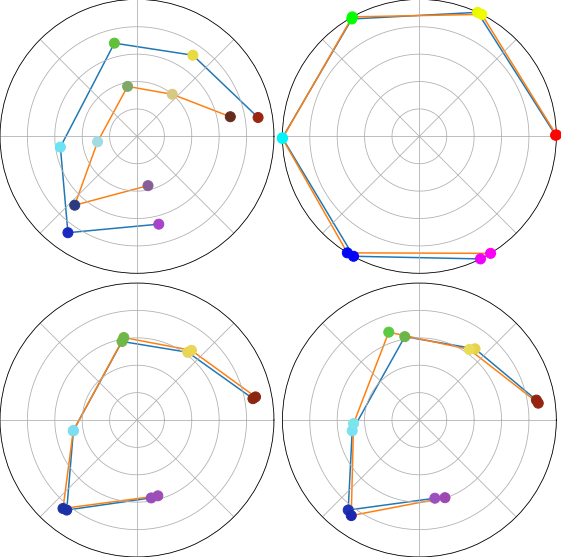

In [33]:
import matplotlib
fig = plt.figure(figsize=(8,8))

wheels = normalised_colour_wheels(runs['flat_lst'])

w, h, channels = wheels.shape
r = min(w//10, h//10)
centre_wheel = (slice(w//2 - r, w//2 + r), slice(h//2 - r, h//2 + r), slice(None))
corner_wheel = (slice(w//10 - r, w//10 + r), slice(h//10 - r, h//10 + r), slice(None))
rois = [centre_wheel, corner_wheel]

corrected_images = {}
corrected_images['In-situ shading'] = wheels
corrected_images['In-situ unmixing (RGB)'] = colour_unmix_image(wheels, runs['flat_lst'], colour_target="rgb")
corrected_images['In-situ unmixing (centre)'] = colour_unmix_image(wheels, runs['flat_lst'], colour_target="centre")
corrected_images['Combination unmixing (centre)'] = colour_unmix_image(wheels, runs['neopixel_jig'], colour_target="centre")

# Go through each image, extract the colour wheels, and pick the colour of each segment
rgb_samples = {}
for i, (name, image) in enumerate(corrected_images.items()):
    colours_per_wheel = []
    for i, rr in enumerate(rois):
        wheel = image[rr]                                      # Crop out the colour wheel
        w, h, channels = wheel.shape
        radius = 0.2
        cx, cy = 0.5, 0.5
        colours_rgb = []
        for a in (np.arange(6.0)-0.5)/8.0*2*np.pi:             # Pick the centre of each segment
            x = (np.sin(a)*radius)*h + cx*w
            y = (np.cos(a)*radius)*h + cy*h
            colours_rgb.append(wheel[int(x), int(y), :])       # Add the colour to the list
            #wheel[int(x), int(y), :] = 0
        colours_per_wheel.append(colours_rgb)
    rgb_samples[name] = colours_per_wheel

for i, name in enumerate(corrected_images.keys()):
    ax = fig.add_subplot(2, 2, i+1, projection='polar')
    for colours in rgb_samples[name]:
        rgb = np.array(colours)/255.0
        rgb[rgb < 0] = 0
        rgb[rgb > 1] = 1
        hsv = matplotlib.colors.rgb_to_hsv(rgb)
        ax.plot(hsv[:,0]*2*np.pi, hsv[:,1], zorder=1)
        ax.scatter(hsv[:,0]*2*np.pi, hsv[:,1], c=rgb, zorder=10, s=100, clip_on=False)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_ylim((0,1.))
fig.tight_layout()

Adding up the R/G/B images, we get: [1.0591428  1.04643386 1.03307055]
Adding up the R/G/B images, we get: [1.02858786 1.0233673  1.02461772]


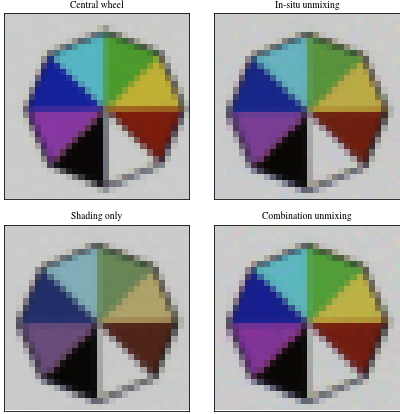

In [34]:
import string

fig, ax = plt.subplots(2, 2, figsize=(6,6))


normalised_image = normalised_colour_wheels(runs['flat_lst'])
w, h, channels = normalised_image.shape
r = min(w//10, h//10)
centre_wheel = (slice(w//2 - r, w//2 + r), slice(h//2 - r, h//2 + r), slice(None))
corner_wheel = (slice(w//10 - r, w//10 + r), slice(h//10 - r, h//10 + r), slice(None))

# First, plot the uncorrected image for comparison
imshow_with_section(ax[0,0], normalised_image[centre_wheel]*0.8, section=False)
ax[0,0].set_title("Central wheel")
imshow_with_section(ax[1,0], normalised_image[corner_wheel]*0.8, section=False)
ax[1,0].set_title("Shading only")

# Next, use the in-situ calibration to correct it
imshow_with_section(ax[0,1], colour_unmix_image(normalised_image, runs['flat_lst'], 
                                                colour_target="centre", smoothing=3)[corner_wheel]*0.8, section=False)
ax[0,1].set_title("In-situ unmixing")


# Compare to the in-jig calibration for unmixing (but still using the in-situ background)
imshow_with_section(ax[1,1], colour_unmix_image(normalised_image, runs['neopixel_jig'], 
                                                colour_target="centre", smoothing=3)[corner_wheel]*0.8, section=False)
ax[1,1].set_title("Combination unmixing")

#for i, axes in enumerate(ax.flat):
#    axes.text(0.05, 0.95, '('+string.ascii_lowercase[i]+')', transform=axes.transAxes, 
#            size=12, weight='bold', ha="left", va="top")
# This is used later on, for the combined figure
    
fig.tight_layout()

'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


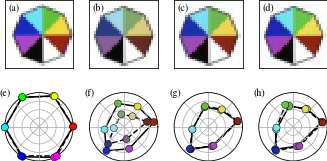

In [35]:
fig = plt.figure(figsize=(manuscript_linewidth,manuscript_linewidth*4/7))


imshow_with_section(fig.add_subplot(2, 4, 1), corrected_images['In-situ shading'][centre_wheel], section=False)
imshow_with_section(fig.add_subplot(2, 4, 2), corrected_images['In-situ shading'][corner_wheel], section=False)
imshow_with_section(fig.add_subplot(2, 4, 3), corrected_images['In-situ unmixing (centre)'][corner_wheel], section=False)
imshow_with_section(fig.add_subplot(2, 4, 4), corrected_images['Combination unmixing (centre)'][corner_wheel], section=False)

for i, name in zip([6,5,7,8], corrected_images.keys()):
    ax = fig.add_subplot(2, 4, i, projection='polar')
    for colours, linestyle in zip(rgb_samples[name], ['-','--']):
        rgb = np.array(colours)/255.0
        rgb[rgb < 0] = 0
        rgb[rgb > 1] = 1
        hsv = matplotlib.colors.rgb_to_hsv(rgb)
        hsv_circ = np.concatenate([hsv, [hsv[0,:]]], axis=0)
        ax.plot(hsv_circ[:,0]*2*np.pi, hsv_circ[:,1], zorder=1, color="black", linestyle=linestyle)
        ax.scatter(hsv[:,0]*2*np.pi, hsv[:,1], c=rgb, zorder=10, s=50, clip_on=False,
                   edgecolors='black', linewidths=0.5)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_ylim((0,1.))
        
for letter, axes in zip("abcdfegh", fig.axes):
    pos = (0.05, 0.95) if axes.name=="rectilinear" else (-0.07, 1.07)
    axes.text(*pos, '('+letter+')', transform=axes.transAxes, 
            size=10, weight='normal', ha="left", va="top", fontdict={'family':'serif'})
    
fig.tight_layout()
fig.savefig("../manuscript/artwork/matrix_correction_wheels_and_polar.pdf")

**Figure:** Images of colour wheels extracted from the centre of a test image (a), and the corner of the same image (b-d).  Below are polar plots of the six coloured segments for the central (solid lines) and corner (dashed lines) wheels of the image (e-h). (b, f) only have vignetting correction, so the saturation is significantly lower in (b), and the two sets of colours are separated in the polar plot (f). (c, g) are unmixed using in-situ calibration, so the colours in (c) match those in (a), and the two sets of colours lie on top of each other in (g). (d, h) are unmixed using a combination of an in-situ white image and single-colour images from the calibration jig; the colours do not match as closely as in (c, g) but are much improved from (b, f). (e) is the same as (g) but unmixed to fully-saturated colours rather than matching the central response, giving oversaturated images and increased noise.

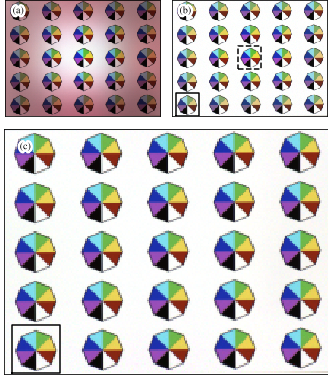

In [36]:
fig = plt.figure(figsize=(manuscript_linewidth,manuscript_linewidth*4.6/4))
gs = matplotlib.gridspec.GridSpec(3,2)

run = runs['flat_lst']
wheels_vignetted = run['colour_wheels']*255./np.max(run['W'], axis=(0,1))

ax0 = fig.add_subplot(gs[0,0])
imshow_with_section(ax0, wheels_vignetted, section=False)
ax1 = fig.add_subplot(gs[0,1])
imshow_with_section(ax1, corrected_images['In-situ shading'], section=False)
ax2 = fig.add_subplot(gs[1:,:])
imshow_with_section(ax2, corrected_images['In-situ unmixing (centre)'], section=False)

# Highlight the central and corner wheels
for slices, line, ax in [(corner_wheel, "k-", ax1), (corner_wheel, "k-", ax2), (centre_wheel, "k--", ax1)]:
    x0, x1, = slices[1].start, slices[1].stop
    y0, y1, = slices[0].start, slices[0].stop
    ax.plot([x0,x1,x1,x0,x0], [y0,y0,y1,y1,y0], line)

import matplotlib.patheffects as pe
for letter, axes in zip("abc", fig.axes):
    pos = (0.05, 0.95) if axes.name=="rectilinear" else (-0.07, 1.07)
    text = axes.text(*pos, '('+letter+')', transform=axes.transAxes, 
                     size=10, weight='normal', ha="left", va="top",
                     fontdict={'family':"serif"})
    text.set_path_effects([pe.Stroke(linewidth=5, foreground='white'),
                           pe.Normal()])

fig.tight_layout()
fig.savefig("../manuscript/artwork/colour_wheels_images.pdf")

**Figure:** Images of the colour wheel test target, with (a) only colour-balance correction $\mathit{Cb}_{qq}$, (b) vignetting correction $\mathit{Cb}_{qq}\mathit{LST}_{ijq}$, and (c) colour-unmixing $\mathit{U}_{ijpq}\mathit{Cb}_{qq}\mathit{LST}_{ijq}$.  The wheels extracted later on are highlighted with boxes.

Below are some plots of the $3\times3$ matrix that performs this calibration:

In [38]:
def plot_compensation_matrix(matrix, r=None, clip_range=1, fig=None, ax=None, cax=None):
    """Plot an NxMx3x3 compensation matrix nicely."""
    if r is None:
        r = max(matrix.max(), -matrix.min())
    r *= clip_range
    if ax is None:
        if fig is None:
            fig, ax = plt.subplots(3,3, figsize=(5,3))
        else:
            ax = np.array([[fig.add_subplot(3,3,i+3*j) for i in range(3)] for j in range(3)])
    for i in range(3):
        for j in range(3):
            implot = ax[i,j].imshow(matrix[:,:,i,j], vmin=-r, vmax=r, cmap="PiYG")
            ax[i,j].xaxis.set_visible(False)
            ax[i,j].yaxis.set_visible(False)
    if cax is None:
        fig.subplots_adjust(right=0.8)
        cax = fig.add_axes([0.85,0.1,0.07,0.8])
    fig.colorbar(implot, cax=cax)
    return fig, ax



Below are the plots of the unmixing matrices for (top) the in-situ calibration and (bottom) calibration in the jig.  The two sets of matrices are similar in magnitude and trend, though the edges of the image do vary slightly, as might be expected from the different apertures used.

Adding up the R/G/B images, we get: [1.0242386  1.02685294 1.01441896]
Adding up the R/G/B images, we get: [1.02858786 1.0233673  1.02461772]


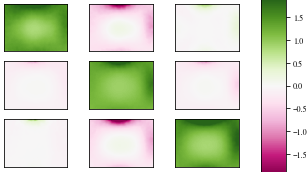

In [39]:
_ = plot_compensation_matrix(colour_unmixing_matrices(runs['tape_aperture_1'], 
                                                      colour_target="centre", 
                                                      smoothing=3), 
                             clip_range=0.5)

_ = plot_compensation_matrix(colour_unmixing_matrices(runs['neopixel_jig'], 
                                                      colour_target="centre", 
                                                      smoothing=3), 
                             clip_range=0.9)


NB these matrices should *only* be unmixing the colour channels to equalise colour response between the centre and the edges; colour balance and vignetting correction are not included (all images are already normalised to the white image).  Also, a Gaussian blur with standard deviation 3 pixels has been applied, to remove noise in the source images.

To compare these more quantitatively, we can plot sections through each of the graphs.  The three plots below show the same 3x3 matrix, in horizontal, vertical, and diagonal sections respectively:

In [40]:
comp_a = colour_unmixing_matrices(runs["flat_lst"], colour_target="centre", smoothing=3)
comp_b = colour_unmixing_matrices(runs["neopixel_jig"], colour_target="centre", smoothing=3)

for section_fn in section_functions:
    f, ax = plt.subplots(3,3,figsize=(6,6), sharex=True, sharey=True)
    for i in range(3):
        for j in range(3):
            for comp, axes, label in [(comp_a, ax[i,j], "In Situ"),
                                      (comp_b, ax[i,j], "In Jig")]:
                axes.plot(section_fn(comp[:, :, i, j]), label=label)
    ax[2,2].legend(loc='lower left', bbox_to_anchor=(1.0, -0.05), ncol=1)
    row_titles(ax[0:3, 0], ["R","G","B"], offset=(-10,0))
    col_titles(ax[0,:], ["R","G","B"])

Adding up the R/G/B images, we get: [1.0591428  1.04643386 1.03307055]
Adding up the R/G/B images, we get: [1.02858786 1.0233673  1.02461772]


As can be seen in the image plots, the calibration worked out in the jig was less extreme than that calculated using the actual imaging system.  This is most likely because of the larger numerical aperture of the imaging system blurring out the vignetting effect.  However, the two calibrations are nonetheless quite similar, and produce at least visually similar results.  If precise colorimetry is required, however, this calibration really ought to be performed in situ.

The "signal" (i.e. the image) for each pixel is calculated as a weighted sum of the RGB components of the original image; $c=\sum a_ip_i$ where $c$ is the output value, $a_i$ are the coefficients (which ultimately come from the matrices we have defined previously) and $p_i$ are the pixel values in the raw image.  In order to unmix colour crosstalk, some of these coefficients $a_i$ will be negative.  On the other hand, noise (assumed to be independent for each colour) will still add up, proportional to $\sqrt{\sum a_i^2}$.  Initially, this analysis estimated the magnitude of the signal as $c=\sum a_ip_i$, but actually it makes more sense just to assume the signal magnitude is roughly constant; the image (after processing) ought not to vary in brightness systematically across the field of view.  That means that the unmixing process (provided it doesn't alter brigtness) will increase the magnitude of noise in the image by around $\sqrt{\sum a_i^2}$.  NB if we calculate this across all colour channels by summing the squared elements of the matrix, we must divide by three to account for the three colour channels.

Adding up the R/G/B images, we get: [1.0591428  1.04643386 1.03307055]
The unmixed-to-RGB image will be 2.3308004536764524 times noisier


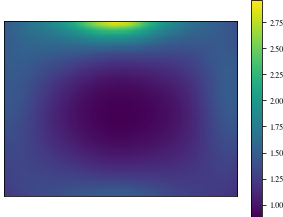

In [41]:
fig, ax = plt.subplots(1,1)
run = runs['flat_lst']
unmixing_matrices = colour_unmixing_matrices(run, colour_target="centre", smoothing=3)
noise = np.sqrt(np.sum(unmixing_matrices**2, axis=(2,3))/3.0)
im = ax.imshow(noise)
#im = ax[1,2].imshow(1/unmixing_snr(colour_unmixing_matrices(run, colour_target="rgb", smoothing=3)), **imshow_params)

noise_rgb = np.sqrt(np.sum(colour_unmixing_matrices(run, colour_target="rgb", smoothing=3)**2, axis=(2,3))/3.0)
print("The unmixed-to-RGB image will be {} times noisier".format(np.mean(noise_rgb/noise)))

for axes in [ax]:
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, ax=ax)

For the centre of the image, there is no additional penalty in signal-to-noise, because the colours are not changed.  Towards the edge of the image, the noise will be roughly double that of the desaturated image.  The fully-unmixed (oversaturated) image will be noisier, but have the same shape (as it is the same unmixing function, multiplied by a 3x3 matrix that does not vary over the image.

Similarly, the initial normalisation will have increased the noise from dimmer regions of the raw image by equalising brightness across the image.  The equivalent plot for that is below:

In [42]:
fig, ax = plt.subplots(1,1)
norm_white = 255./runs['flat_lst']['W']
norm_white /= np.max(norm_white)
noise = np.sqrt(np.sum(norm_white**2, axis=(2))/3.0)
im = ax.imshow(noise)
#im = ax[1,2].imshow(1/unmixing_snr(colour_unmixing_matrices(run, colour_target="rgb", smoothing=3)), **imshow_params)

for axes in [ax]:
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
fig.subplots_adjust(right=0.8)
plt.colorbar(im, ax=ax)

For the paper, I'll plot the two SNR graphs and the matrix together:

In [43]:
fig = plt.figure(figsize=(manuscript_linewidth,manuscript_linewidth*0.45))
gs = matplotlib.gridspec.GridSpec(5,5,
                                  width_ratios=(0.3, 0.3, 0.3, 0.9, 0.9, ),
                                  height_ratios=(0.3, 0.3, 0.3, 0.1, 0.1, ),
                                  wspace=0.1, hspace=0.1)
image_axes = []

run = runs['flat_lst']
unmixing_matrices = colour_unmixing_matrices(run, colour_target="centre", smoothing=3)
norm_white = 255./runs['flat_lst']['W']
norm_white /= np.min(norm_white, axis=(0,1))

# Plot the unmixing matrix
r = max(unmixing_matrices.max(), -unmixing_matrices.min()) * 0.7
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(gs[j,i])
        image_axes.append(ax)
        implot = ax.imshow(unmixing_matrices[:,:,i,j] - (0 if i==j else 0), vmin=-r, vmax=r, cmap="PiYG")
plt.colorbar(implot, cax=fig.add_subplot(gs[3,:3]), orientation="horizontal")

# Plot the noise penalty
image_axes.append(fig.add_subplot(gs[:3,3]))
implot = image_axes[-1].imshow(np.sqrt(np.sum(unmixing_matrices**2, axis=(2,3))/3.0))
plt.colorbar(implot, cax=fig.add_subplot(gs[3,3]), orientation="horizontal")

# Plot the noise penalty from the vignetting correction
image_axes.append(fig.add_subplot(gs[:3,4]))
implot = image_axes[-1].imshow(np.sqrt(np.sum(norm_white**2, axis=(2))/3.0), vmin=1.0)
plt.colorbar(implot, cax=fig.add_subplot(gs[3,4]), orientation="horizontal")

for ax in image_axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

        
for letter, i, color in zip("abc", [2,9,10], ['black','white','black']):
    axes = image_axes[i]
    axes.text(0.0, 0.05, ' ('+letter+')', transform=axes.transAxes, 
            size=10, weight='normal', ha="left", va="bottom", color=color)
gs.update(left=0.02, right=0.98)
    
#fig.tight_layout()
fig.savefig("../manuscript/artwork/unmixing_matrix_and_snr.pdf")

'texgyretermes-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Adding up the R/G/B images, we get: [1.0591428  1.04643386 1.03307055]


**Figure**: (a) A representation of the $3\times 3$ spatially-varying matrix that unmixes the colour channels at the edge of the image.  Crosstalk is strongest between green and the other two channels due to the spatial arrangement of the Bayer pattern, which means red and blue are never adjacent pixels. (b) The increase in noise in the image, due to the unmixing of the colour channels by the matrix in (a).  This is when the colours are normalised to the centre of the image; if the colours are fully unmixed, the oversaturated image has $2.3$ times more noise again.  (c) The additional noise penalty of normalising the image to correct for vignetting.

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(7,3.5))
col_titles(ax[0,:], ["Vignetting only", "Normalised to centre", "Fully unmixed"])
row_titles(ax[:,0], ["Test image", "SNR penalty"])
imshow_params = {"vmin": 1, "vmax": 5}

# First, plot the uncorrected image for comparison
run = runs['flat_lst']
normalised_image = normalised_colour_wheels(run)
imshow_with_section(ax[0,0], normalised_image, section=False)
ax[1,0].imshow(np.ones_like(normalised_image[:,:,0]), **imshow_params)

# Next, plot it normalised to the centre
imshow_with_section(ax[0,1], colour_unmix_image(normalised_image, run, 
                                                colour_target="centre", smoothing=3), section=False)
ax[1,1].imshow(1/unmixing_snr(colour_unmixing_matrices(run, colour_target="centre", smoothing=3)), **imshow_params)

# Finally, plot it unmixed to RGB
imshow_with_section(ax[0,2], colour_unmix_image(normalised_image, run, 
                                                colour_target="rgb", smoothing=3), section=False)
im = ax[1,2].imshow(1/unmixing_snr(colour_unmixing_matrices(run, colour_target="rgb", smoothing=3)), **imshow_params)

for axes in ax[1,:]:
    axes.xaxis.set_visible(False)
    axes.yaxis.set_visible(False)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(im, cax=cbar_ax)
    
#fig.tight_layout()

Adding up the R/G/B images, we get: [1.0591428  1.04643386 1.03307055]


NameError: name 'unmixing_snr' is not defined

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(8,6))
image = runs['flat_lst']['colour_wheels'].copy()
white = runs['flat_lst']['W'].copy()
norm_centre = 255/np.max(white, axis=(0,1))
norm_white = 255/white
w, h, channels = image.shape
rr = (slice(2*w//5, 3*w//5), slice(2*h//5,None), slice(None))
imshow_with_section(ax[0], image[rr]*norm_centre*0.9, section=False)
imshow_with_section(ax[1], image[rr]*norm_white[rr]*0.9, section=False)
imshow_with_section(ax[2], colour_unmix_image(image*norm_white, runs['flat_lst'], 
                                              colour_target="centre", smoothing=3)[rr]*0.9, section=False)
imshow_with_section(ax[3], colour_unmix_image(image*norm_white, runs['flat_lst'], 
                                              colour_target="rgb", smoothing=3)[rr]*0.9, section=False)
row_titles(ax[:],["Raw","Vignetting","Unmixed\nto centre", "Unmixed\nto RGB"], offset=(35,0))
fig.tight_layout()

If we test using the uniform calibration images, that's not an out-of-band measurement; those will be perfect by definition.  Instead, a fairer test is to use a calibration test with all of the colours in it.  For this, we used a screen several metres away, and a f=50mm lens.  The plots below show the image recovered with full saturation ($\mathit{U}_{ijpq}\mathit{Cx}_{qr}$) and normalised to the centre ($\mathit{U}_{ijpq}$).  This figure also calculates the signal-to-noise ratio for each correction.

## Summary
This notebook has outlined several methods - normalising using a single RGB image (equivalent to the "lens shading table" in the Pi Camera's GPU pipeline) and using two different matrices, one of which removes colour crosstalk and gives artificially saturated images, the other removes only the *additional* crosstalk due to the angle-dependent lenslet array on the sensor.  The third of these methods seems to strike a good compromise between providing uniform images, minimising noise, and faithfully reproducing colours across the whole sensor.  The figure below shows the results for each method.

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(8,4))
image = runs['flat_lst']['colour_wheels'].copy()
white = runs['flat_lst']['W'].copy()
norm_centre = 255/np.max(white, axis=(0,1))
norm_white = 255/white
w, h, channels = image.shape

rois = [centre_wheel, corner_wheel]
for i, rr in enumerate(rois):
    imshow_with_section(ax[i, 0], image[rr]*norm_centre, section=False)
    imshow_with_section(ax[i, 1], image[rr]*norm_white[rr], section=False)
    imshow_with_section(ax[i, 2], colour_unmix_image(image*norm_white, runs['flat_lst'], 
                                              colour_target="centre", smoothing=3)[rr]*0.99, section=False)
    imshow_with_section(ax[i, 3], colour_unmix_image(image*norm_white, runs['flat_lst'], 
                                              colour_target="rgb", smoothing=3)[rr]*0.99, section=False)
col_titles(ax[0,:],["Unnormalised","Shading","Matrix (centre)","Matrix (extreme)"])
row_titles(ax[:,0],["Centre", "Corner"], offset=(24,0))
fig.tight_layout()